In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torchsummary
import torch.nn as nn
import torch.optim as optim

In [3]:
import os
import sys
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
root_name = os.path.basename(project_root)

In [4]:
from src.dataloader import get_data_loaders
from src.model import EffcientNetDF
from src.utils import set_seed, train_one_epoch, evaluate, save_checkpoint, save_experiment_json, get_device, performance

In [32]:
DATA_ROOT = '../data/images'
RESULTS_DIR = '../results'
MODEL_NAME = 'efficientnet'
TASK_NAME = 'deepfake_detecction_aug'

In [6]:
BATCH_SIZE = 32

# Train Head Only
EPOCHS_STAGE_1 = 10
LR_STAGE_1 = 0.001

# Fine-Tune
EPOCHS_STAGE_2 = 20
LR_STAGE_2 = 0.0001

In [7]:
torch.backends.cudnn.benchmark = True

In [8]:
DEVICE = torch.device(get_device())
BENCHMARK = torch.backends.cudnn.benchmark

In [9]:
print(f"Project path: {root_name}")
print(f"Device: {DEVICE}")
print(f"Benchmark: {BENCHMARK}")

Project path: deep_fake_detection
Device: cuda
Benchmark: True


In [10]:
train_loader, valid_loader = get_data_loaders(DATA_ROOT, "efficientnet", 32)

Class expected: ['real', 'fake']
Class found: {'real', 'fake'}


In [11]:
model = EffcientNetDF(num_classes=2, pretrained=True).to(DEVICE)
torchsummary.summary(model, (3, 224, 224), BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
              SiLU-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
              SiLU-6         [32, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [32, 32, 1, 1]               0
            Conv2d-8              [32, 8, 1, 1]             264
              SiLU-9              [32, 8, 1, 1]               0
           Conv2d-10             [32, 32, 1, 1]             288
          Sigmoid-11             [32, 32, 1, 1]               0
SqueezeExcitation-12         [32, 32, 112, 112]               0
           Conv2d-13         [32, 16, 112, 112]             512
      BatchNorm2d-14         [32, 16, 1

In [12]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "EPOCHS": EPOCHS_STAGE_1 + EPOCHS_STAGE_2,
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": ""
}

best_acc = 0.0

In [13]:
# Freeze Backbone
for param in model.model.features.parameters():
    param.requires_grad = False
    
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters (stage 1): {trainable_params}")

Trainable parameters (stage 1): 2562


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_1)

In [15]:
for epoch in range(EPOCHS_STAGE_1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    print(f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../results/best_{MODEL_NAME}.pth"
        save_checkpoint(model, optimizer, save_name)
        
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.76it/s]


[1/10] train_acc: 0.5727 - train_loss: 0.6821 - valid_acc: 0.6240 - valid_loss: 0.6409
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 1 - acc: 0.6240



Evaluating: 100%|██████████| 125/125 [00:30<00:00,  4.14it/s]


[2/10] train_acc: 0.5861 - train_loss: 0.6740 - valid_acc: 0.6398 - valid_loss: 0.6354
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 2 - acc: 0.6398



Evaluating: 100%|██████████| 125/125 [00:30<00:00,  4.12it/s]


[3/10] train_acc: 0.5851 - train_loss: 0.6767 - valid_acc: 0.6212 - valid_loss: 0.6559
	- [current best] epoch: 2 - acc: 0.6398



Evaluating: 100%|██████████| 125/125 [00:38<00:00,  3.27it/s]


[4/10] train_acc: 0.5908 - train_loss: 0.6734 - valid_acc: 0.5933 - valid_loss: 0.6742
	- [current best] epoch: 2 - acc: 0.6398



Evaluating: 100%|██████████| 125/125 [00:26<00:00,  4.67it/s]


[5/10] train_acc: 0.5908 - train_loss: 0.6750 - valid_acc: 0.6310 - valid_loss: 0.6417
	- [current best] epoch: 2 - acc: 0.6398



Evaluating: 100%|██████████| 125/125 [00:23<00:00,  5.26it/s]


[6/10] train_acc: 0.5994 - train_loss: 0.6708 - valid_acc: 0.6465 - valid_loss: 0.6306
Checkpoint saved: ../results/best_efficientnet.pth
	- [current best] epoch: 6 - acc: 0.6465



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.75it/s]


[7/10] train_acc: 0.5876 - train_loss: 0.6759 - valid_acc: 0.5995 - valid_loss: 0.6686
	- [current best] epoch: 6 - acc: 0.6465



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.76it/s]


[8/10] train_acc: 0.5860 - train_loss: 0.6773 - valid_acc: 0.6425 - valid_loss: 0.6336
	- [current best] epoch: 6 - acc: 0.6465



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.00it/s]


[9/10] train_acc: 0.5886 - train_loss: 0.6763 - valid_acc: 0.6210 - valid_loss: 0.6512
	- [current best] epoch: 6 - acc: 0.6465



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.75it/s]

[10/10] train_acc: 0.5956 - train_loss: 0.6724 - valid_acc: 0.6435 - valid_loss: 0.6381
	- [current best] epoch: 6 - acc: 0.6465



In [16]:
# Unfreeze for Fine-Tuning
for param in model.parameters():
    param.requires_grad = True

In [17]:
optimizer = optim.Adam(model.parameters(), lr=LR_STAGE_2)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable Parameters (Stage 2): {trainable_params}")

Trainable Parameters (Stage 2): 4010110


In [19]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, valid_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_name = f"../results/best_{MODEL_NAME}_finetuned.pth"
        save_checkpoint(model, optimizer, save_name) 
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = save_name
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Evaluating: 100%|██████████| 125/125 [00:21<00:00,  5.87it/s]


[11/30 (Fine-Tune)] train_acc: 0.7110 - train_loss: 0.5475 - valid_acc: 0.8390 - valid_loss: 0.3560
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 11 - acc: 0.8390



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.24it/s]


[12/30 (Fine-Tune)] train_acc: 0.8007 - train_loss: 0.4163 - valid_acc: 0.8530 - valid_loss: 0.3749
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 12 - acc: 0.8530



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.89it/s]


[13/30 (Fine-Tune)] train_acc: 0.8357 - train_loss: 0.3546 - valid_acc: 0.8460 - valid_loss: 0.4268
	- [current best] epoch: 12 - acc: 0.8530



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.01it/s]


[14/30 (Fine-Tune)] train_acc: 0.8617 - train_loss: 0.3133 - valid_acc: 0.8648 - valid_loss: 0.3513
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 14 - acc: 0.8648



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.87it/s]


[15/30 (Fine-Tune)] train_acc: 0.8748 - train_loss: 0.2804 - valid_acc: 0.8690 - valid_loss: 0.3577
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 15 - acc: 0.8690



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.77it/s]


[16/30 (Fine-Tune)] train_acc: 0.8861 - train_loss: 0.2557 - valid_acc: 0.9000 - valid_loss: 0.2875
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 16 - acc: 0.9000



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.09it/s]


[17/30 (Fine-Tune)] train_acc: 0.9007 - train_loss: 0.2320 - valid_acc: 0.9135 - valid_loss: 0.2624
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 17 - acc: 0.9135



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.04it/s]


[18/30 (Fine-Tune)] train_acc: 0.9088 - train_loss: 0.2149 - valid_acc: 0.9115 - valid_loss: 0.2689
	- [current best] epoch: 17 - acc: 0.9135



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.23it/s]


[19/30 (Fine-Tune)] train_acc: 0.9170 - train_loss: 0.1978 - valid_acc: 0.9113 - valid_loss: 0.3042
	- [current best] epoch: 17 - acc: 0.9135



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.34it/s]


[20/30 (Fine-Tune)] train_acc: 0.9194 - train_loss: 0.1880 - valid_acc: 0.9115 - valid_loss: 0.3287
	- [current best] epoch: 17 - acc: 0.9135



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.36it/s]


[21/30 (Fine-Tune)] train_acc: 0.9264 - train_loss: 0.1735 - valid_acc: 0.9275 - valid_loss: 0.2567
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 21 - acc: 0.9275



Evaluating: 100%|██████████| 125/125 [00:28<00:00,  4.31it/s]


[22/30 (Fine-Tune)] train_acc: 0.9313 - train_loss: 0.1668 - valid_acc: 0.8842 - valid_loss: 0.3827
	- [current best] epoch: 21 - acc: 0.9275



Evaluating: 100%|██████████| 125/125 [00:17<00:00,  7.06it/s]


[23/30 (Fine-Tune)] train_acc: 0.9310 - train_loss: 0.1614 - valid_acc: 0.9197 - valid_loss: 0.2702
	- [current best] epoch: 21 - acc: 0.9275



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.41it/s]


[24/30 (Fine-Tune)] train_acc: 0.9401 - train_loss: 0.1459 - valid_acc: 0.9133 - valid_loss: 0.2639
	- [current best] epoch: 21 - acc: 0.9275



Evaluating: 100%|██████████| 125/125 [00:20<00:00,  6.07it/s]


[25/30 (Fine-Tune)] train_acc: 0.9414 - train_loss: 0.1412 - valid_acc: 0.9183 - valid_loss: 0.2732
	- [current best] epoch: 21 - acc: 0.9275



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.80it/s]


[26/30 (Fine-Tune)] train_acc: 0.9455 - train_loss: 0.1333 - valid_acc: 0.9075 - valid_loss: 0.3595
	- [current best] epoch: 21 - acc: 0.9275



Evaluating: 100%|██████████| 125/125 [00:18<00:00,  6.65it/s]


[27/30 (Fine-Tune)] train_acc: 0.9507 - train_loss: 0.1237 - valid_acc: 0.9145 - valid_loss: 0.3035
	- [current best] epoch: 21 - acc: 0.9275



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.56it/s]


[28/30 (Fine-Tune)] train_acc: 0.9504 - train_loss: 0.1207 - valid_acc: 0.9277 - valid_loss: 0.2746
Checkpoint saved: ../results/best_efficientnet_finetuned.pth
	- [current best] epoch: 28 - acc: 0.9277



Evaluating: 100%|██████████| 125/125 [00:19<00:00,  6.26it/s]


[29/30 (Fine-Tune)] train_acc: 0.9542 - train_loss: 0.1137 - valid_acc: 0.9170 - valid_loss: 0.3805
	- [current best] epoch: 28 - acc: 0.9277



Evaluating: 100%|██████████| 125/125 [01:31<00:00,  1.37it/s]

[30/30 (Fine-Tune)] train_acc: 0.9562 - train_loss: 0.1104 - valid_acc: 0.9180 - valid_loss: 0.3055
	- [current best] epoch: 28 - acc: 0.9277



<Figure size 1200x600 with 0 Axes>

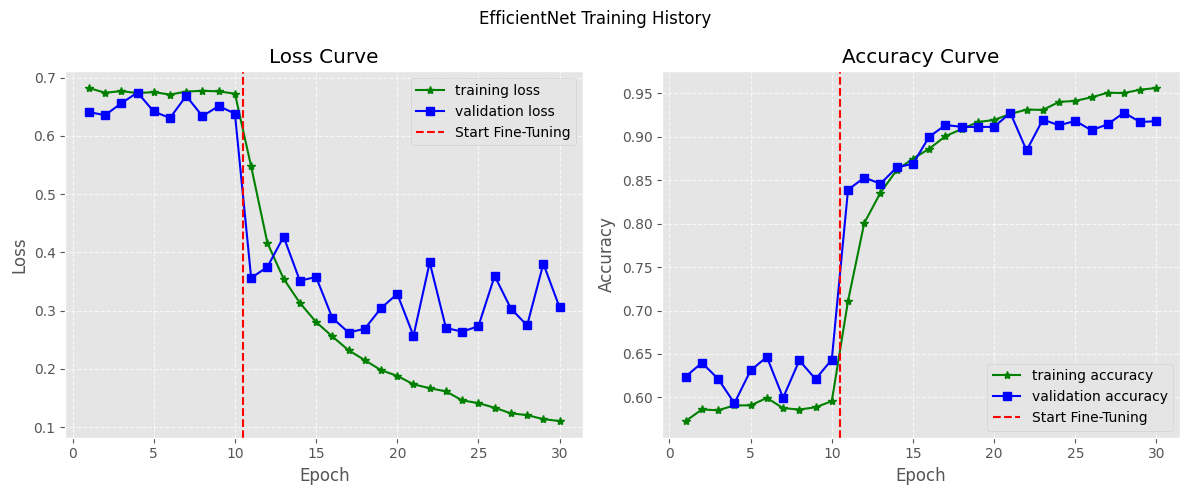

In [33]:
import matplotlib.pyplot as plt

# MODEL_NAME = 'efficientnet'

plt.style.use('ggplot')
plt.figure(figsize=(12, 6))

epochs = range(1, len(history["train_losses"]) + 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

plt.suptitle("EfficientNet Training History")

ax[0].plot(epochs, history["train_losses"], label='training loss', marker='*', color='green')
ax[0].plot(epochs, history["val_losses"], label='validation loss', marker='s', color='blue')
ax[0].set_title("Loss Curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid(True, linestyle='--', alpha=0.7)
ax[0].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[0].legend()

ax[1].plot(epochs, history["train_accuracy"], label='training accuracy', marker='*', color='green')
ax[1].plot(epochs, history["val_accuracy"], label='validation accuracy', marker='s', color='blue')
ax[1].set_title("Accuracy Curve")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True, linestyle='--', alpha=0.7)
ax[1].axvline(x=EPOCHS_STAGE_1 + 0.5, color='red', linestyle='--', label='Start Fine-Tuning')
ax[1].legend()

img_save = f"../results/{MODEL_NAME}_{TASK_NAME}.png"
plt.savefig(img_save)
plt.tight_layout()
plt.show()

In [20]:
json_filename = f"../results/{MODEL_NAME}_{TASK_NAME}.json"
save_experiment_json(history, json_filename)

History saved to ../results/efficientnet_deepfake_detecction_aug.json


Accuracy score: 0.9180


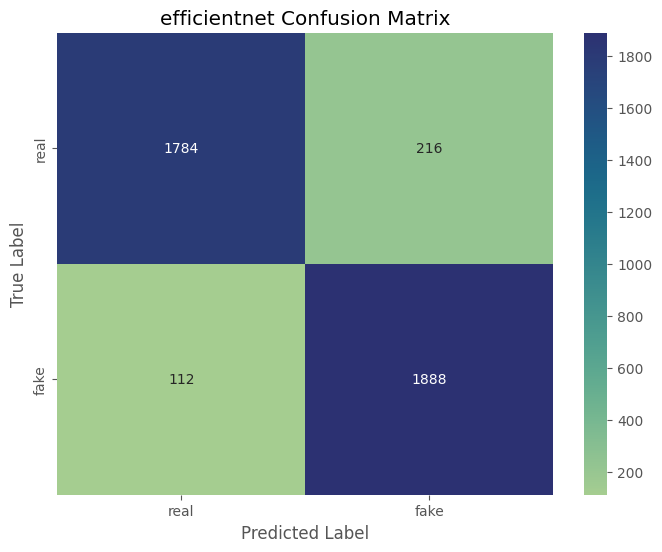

In [ ]:
performance(model, valid_loader, DEVICE, MODEL_NAME, TASK_NAME)